Created by Jason Chen, under Professor Krzysztof Fidkowski

# Problem Statement
The quality and runtime of a CFD solution is highly dependent on the mesh, and although good methods exist to automate mesh refinement, initial mesh generation techiques remain poor at capturing where refinement should take place, and to what degree. The goal of this project is to replicate and build off of work done by [Ohja, Chen, and Fidkowski](https://websites.umich.edu/~kfid/MYPUBS/Ojha_Chen_Fidkowski_2022.pdf), which performs anisotropic mesh generation on simple 2D airfoils. The subsequent mesh optimization process (typically done by routines like MOESS) is out of the scope of this project.

| ![run1_mesh.png](/home/jasonyc/code/research/ml-meshing/images/run1_mesh.png) | 
|:--:| 
| **Figure 1:** A near-optimally meshed airfoil used for training. |

# Background
Anisotropy, meaning when the elements in the mesh are noncongruent, is represented mathematically by a **metric field**. A metric field can be thought of as a measuring stick—it defines distances between points in space, or more precisely (paraphrasing from the cited paper above), for a metric field $M$ and a point in space $\vec{x}$, $M(\vec{x})$ measures the distance from $\vec{x}$ to a point infinitesimally far away, $\vec{x} + \delta \vec{x}$.

Since our problem is in 2 dimensions, $M$ is represented by a 2x2 SPD (symmetric positive definite) matrix. To break down this definition:

- **Symmetric**: $M = M^T$
- **Positive Definite**: The eigenvalues of the metric are all real and positive, meaning the matrix's behavior is "well-defined" and thus there are no directions $x$ where $x^T M x \leq 0$

## Measuring Distance
As an aside, we'll dive into why and how $x^T M x$ represents a distance. I've taken Math 419 but I found that I needed to brush up on linear algebra for this. Feel free to skip this section.

Firstly, how do we define the notion of length for a vector? We take the dot product of the vector with itself:
$$ \vec{x} \cdot \vec{x} = \lVert {\vec{x}} \rVert^2 $$
We can rewrite this:
$$ x^T x = x^T I x = \lVert {\vec{x}} \rVert^2 $$
Here, $I$ is the identity matrix. Thus, it implies that a metric such that $M = I$ is our "typical" notion of distance, without the local stretching.

The expression $x^T M x$ is also called a **quadratic form**:
$$ x^T M x = \sum_{i,j}^{} M_{i,j} x_i x_j $$
which combines the components of $x$ using $M$, and can be used to represent a polynomial using matrices. For example, given that:
$$ M = \begin{bmatrix}
3 & -2 \\
-2 & 7
\end{bmatrix} $$
we can compute:
$$
x^T M x = \begin{bmatrix} x_1 & x_2 \end{bmatrix} \begin{bmatrix}
3 & -2 \\
-2 & 7
\end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix}
$$
$$
= 3 x_1 x_1 - 2 x_1 x_2 - 2 x_2 x_1 + 7 x_2 x_2 = 3 x_1^2 - 4 x_1 x_2 + 7 x_2^2
$$

We can see that if $M$ is a diagonal matrix, i.e. $M = \lambda_i I$, the cross product term (involving both $x_1$ and $x_2$) does not exist and we are left with the square of the components times $\lambda_i$. In other words, each component $x_i$ is scaled by the corresponding eigenvalue $\lambda_i$:
$$ x^T M x = \lambda_1 x_1^2 + \lambda_2 x_2^2 + ... $$

In the more general case, take an SPD matrix $M$. The eigenvalues of $M$ represent the magnitude of scaling (shrinking or stretching, as seen above), and will not result in negative distances since $\lambda_i > 0$ by definition of SPD. The eigenvectors will represent the principal directions of this scaling. 

We can show this mathematically through diagonalization. Since $M$ is symmetric, we can diagonalize it:
$$ M = SDS^{-1} $$
More specifically, because $M$ is real and symmetric, $S$ is an orthogonal matrix, i.e. its columns contain linearly independent vectors (eigenvectors of $M$) and $S$ exhibits the property that $S^{-1} = S^T$. $D$ is a diagonal matrix with each entry being the eigenvalues of $M$.

Next, we can express $x$ in the new basis (defined by the eigenvectors of $M$) with:
$$ y = S^T x $$
This is a simple change of basis. Since each column of S contains eigenvectors, $S^T x$ essentially computes the dot product of each basis vector with $x$, and so $y$ represents $x$ in the new basis. We can then substitute $x = Sy$ in, noting that $S^T S = S^{-1} S = I$:
$$ x^T M x = (Sy)^T (S D S^{-1}) (Sy) = y^T S^T S D S^{-1} S y = y^T D y$$
Since $D$ is diagonal, this simplifies to:
$$ x^T M x = y^T D y = \sum_{i=1}^{n} \lambda_i y_i^2 $$
and so the quadratic form $x^T M x$ measures a **generalized squared distance** in the transformed space.

## Metric Fields Applied to Meshing
Since a metric field represents stretching along the axes of its eigenvectors, if we plot a set of points a unit distance away from a certain point $\vec{x}$ with metric $M$, we will get an ellipse. The direction of the major and minor axes are given by the eigenvectors, and the length of each axis (stretching) is the inverse square root of the corresponding eigenvalue. This means we can visualize the metric fields given a mesh, but first, we'll need to understand how we are encoding the mesh data.

### Mesh Data Format
Meshes are given in `.gri` files under the `meshes/` directory. Within these files, the first section (first couple hundred lines) give two numbers separated by a space, which are $(x,y)$ pairs of coordinates representing a node. This section ends once a following line in the file looks something like this: `52 2 Outflow`. This is a boundary label, which calls out edges that define boundary conditions when running FEA/CFD, but are not necessarily useful right now. The section that defines our elements follows a label that looks like: `1670 1 TriLagrange`. "Trilagrange" is the key word to look out for here, and we can note that the data following this label is a set of three integers. Each integer corresponds with a node, which was numbered (indexed) when we ingested the first section at the beginning of the file. These three nodes together define a triangular element.

## Plotting Ellipses
So, we can ingest the `.gri` file and plot the mesh using `plotmesh.py` (implementation and derivation will be skipped here since it's pretty tedious but relatively straightforward). To plot the metric field ellipses corresponding with each element, we perform the following routine:

**Assumptions**

- The metric field is constant across an element
- Each node of an element is a unit distance (1) away from each other, i.e. the edges (denoted $\delta \vec{x}$) have length 1 as defined by the local metric field $M$

**Routine**

- Go through all elements
- For each element, get the (x,y) coordinates of each of its 3 nodes
- Compute the edge vectors by simple vector subtraction $\delta \vec{x}$
- For each edge, we have the equation $1 = \delta \vec{x}^T M \delta \vec{x}$ where M is the unknown 2x2 metric field with entries $(a, b, b, c)$
- Since we have three edges, we will have 3 equations and 3 unknowns, and solve
- Once we have the metric field, compute its eigenvalues and eigenvectors, and plot the ellipse

The code below is a copy of the file `plotmesh.py`, for demonstration purposes.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from readgri import readgri


def plot_metric_fields(mesh: dict, ax: plt.Axes):
    """
    Plot the metric field ellipses. This function relies in the dictionaries
    for elements and vertices to already be filled by the `readgri.py` module.
    """
    V = mesh['V']; E = mesh['E']
    for i, element in enumerate(E):
        # Each vertex contains three (x,y) tuple coordinates
        verts = [V[v_ind] for v_ind in element]
        centroid = np.asarray([np.mean([v[0] for v in verts]),
                               np.mean([v[1] for v in verts])])
        delta_x = [verts[i] - verts[i-1] for i in range(len(verts))]
        # Assemble a matrix of the quadratic form for each edge
        A_mat = [[vec[0]**2, 2*vec[0]*vec[1], vec[1]**2] for vec in delta_x]
        A_mat = np.reshape(np.asarray(A_mat), (3,3))
        # Solve the system of equations by inverting A
        soln_abc = np.matmul(np.linalg.inv(A_mat), np.ones((3,1))).flatten()
        M_mat = np.array([[soln_abc[0], soln_abc[1]],
                          [soln_abc[1], soln_abc[2]]])
        # Extract eigenvalues and eigenvectors and plot
        eig_vals, eig_vecs = np.linalg.eig(M_mat)
        major_ax_i = np.argmax(eig_vals)
        minor_ax_i = int(not major_ax_i)
        axes_scales = np.zeros(len(eig_vals))
        axes_scales[major_ax_i] = eig_vals[major_ax_i]**(-1/2)
        axes_scales[minor_ax_i] = eig_vals[minor_ax_i]**(-1/2)
        # Angle of the major axis with the global (plotting) coordinate frame
        angle_major = np.arctan2(eig_vecs[major_ax_i][1],
                                 eig_vecs[major_ax_i][0])
        if i % 10 == 0:  # Only plotting every 10th ellipse here
            ellipse = Ellipse(centroid, axes_scales[major_ax_i],
                              axes_scales[minor_ax_i],
                              angle=-angle_major*180/np.pi,
                              facecolor='blue', alpha=0.5)
            ax.add_patch(ellipse)


def plotmesh(mesh: dict):
    """
    Plot the mesh itself. This also calls the metric field plotting function.
    """
    V = mesh['V']; E = mesh['E']; BE = mesh['BE']
    fig, ax = plt.subplots(dpi=300)
    plt.triplot(V[:,0], V[:,1], E, 'k-')
    for i in range(BE.shape[0]):
        plt.plot(V[BE[i,0:2],0], V[BE[i,0:2],1], linewidth=0.1, color='black')
    plot_metric_fields(mesh, ax)
    ax = plt.gca()
    ax.set_xlim([-1, 2])
    ax.set_ylim([-2, 2])
    plt.tick_params(axis='both')
    plt.show()
    plt.close(fig)

Now, we'll run the plotting routine. We're ingesting the `.gri` file specified with `file_name`, which is the same file as shown in Figure 1.

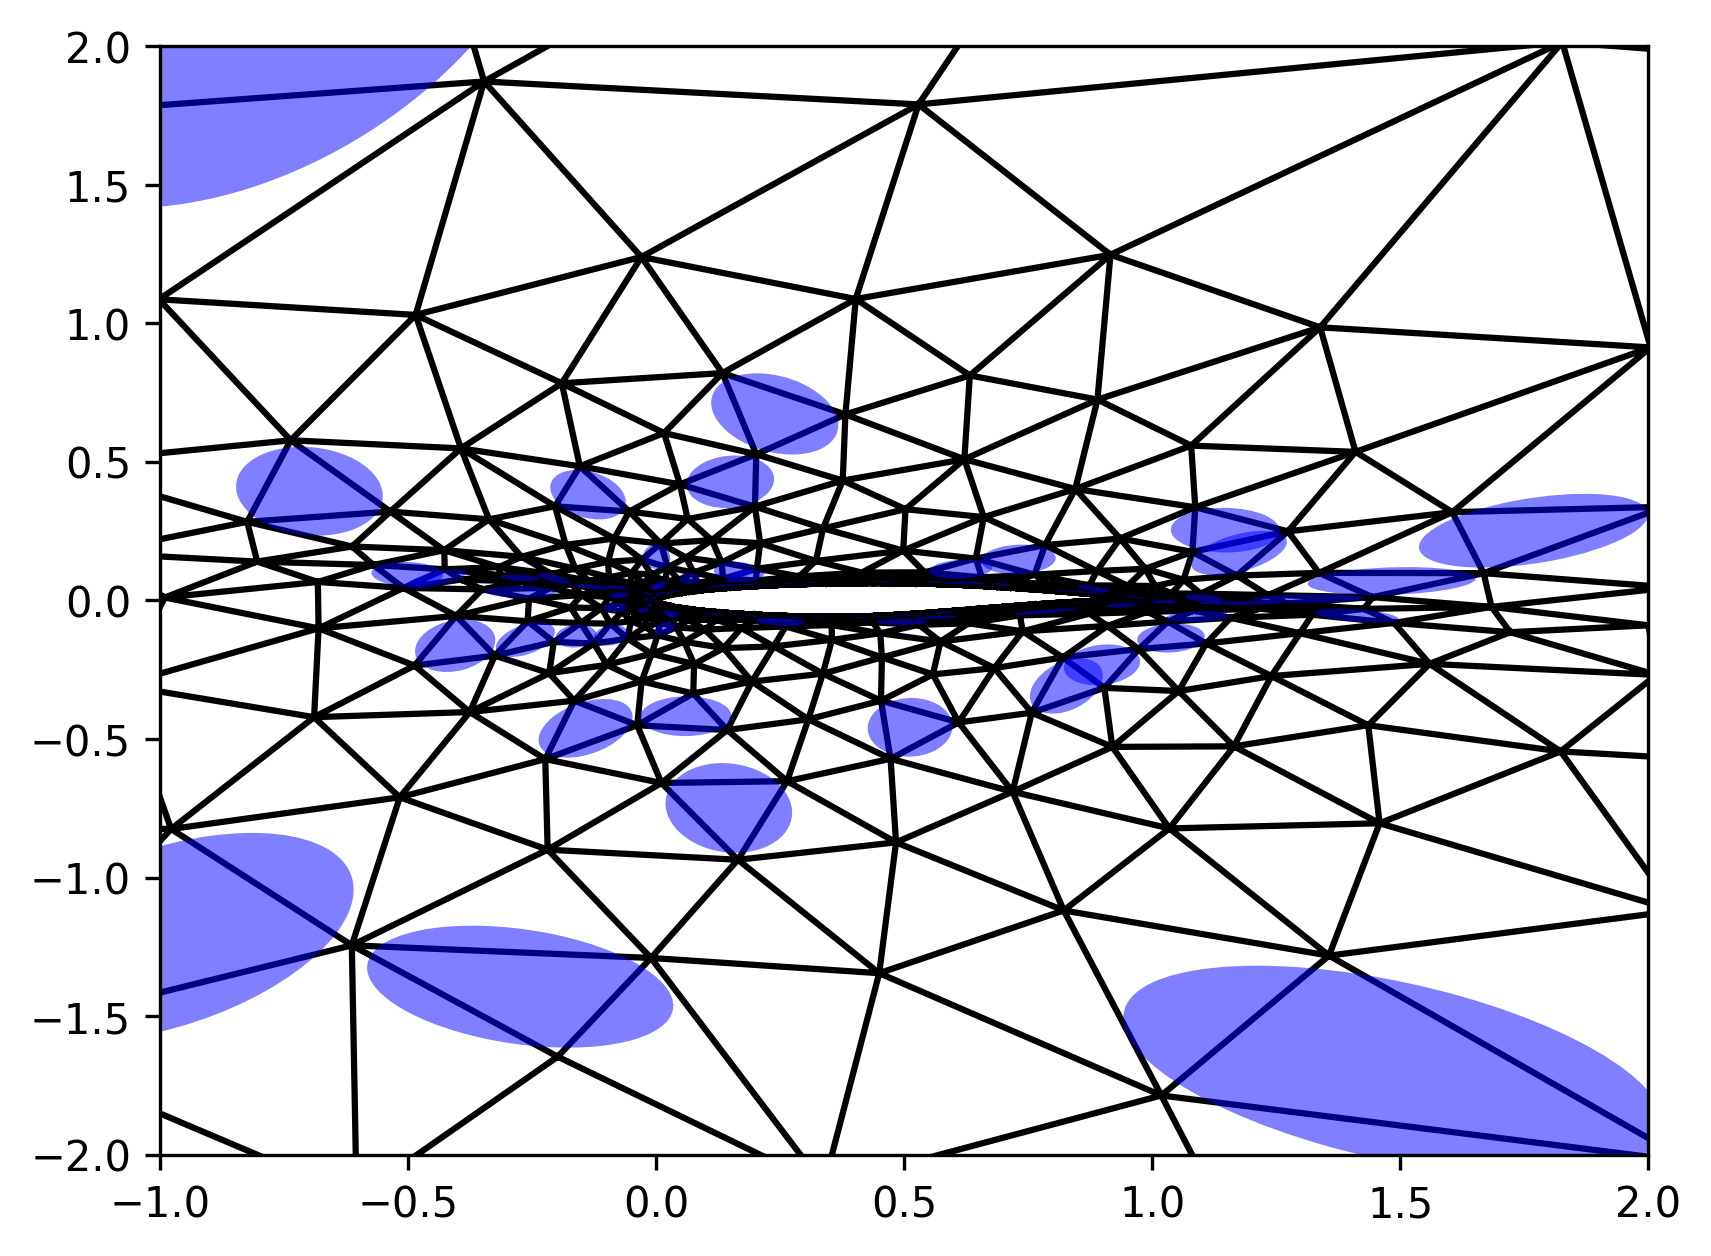

In [11]:
file_name = 'meshes/run1.gri'
plt.style.use('fast')
mesh = readgri(file_name)
plotmesh(mesh)

# Approach
The general approach for tackling this problem is to supply a neural network with training data that pairs the location of a mesh element (x, y, distance from the wall of the airfoil) with the desired metric field. 


## Tools
The python packages required for this project are listed under `requirements.txt` and can be installed with:
```bash
pip3 install -r requirements.txt
```
I chose to use [PyTorch](https://pytorch.org/) because it is well-known for being Pythonic, has plenty of supporting documentation and tutorials, and is just as fast as any other ML library (uses Tensorflow C/C++ backend).


## Neural Network Architecture
The architecture of the neural network replicates what was done in the cited paper. There is a **spatial network**, which takes 3 inputs: the (x,y) position of the centroid of an element, as well as the average wall distance of each of its nodes, and maps it to 10 output neurons. There is also a **parameter network**, which also processes 3 inputs: the natural logarithm of the Reynolds number (taking the log as a way for normalization, reducing the magnitude of this number), Mach number, and angle of attack in radians, and maps these to 10 output neurons. The outputs of these networks are then combined and passed through more hidden layers until a final output layer of 3 neurons.

| ![nn_graphic.png](/home/jasonyc/code/research/ml-meshing/images/nn_graphic.png) | 
|:--:| 
| **Figure 2:** The neural network architecture. |

The output of the entire architecture are the a, b, c entries of the **matrix logarithm** of the metric field. This is done for two reasons: first, like for Reynolds number, doing so reduces the magnitude of the network output. Secondly, because the output is symmetric by nature (only allowing 3 outputs), taking the matrix exponential of this output guarentees that the resulting matrix is an SPD matrix (i.e. a valid metric field).

The actual architecture implemented does not follow Figure 2 exactly, as I found I needed to add more hidden layers to drive loss down to a lower point. The network definition is shown in the code below—we use `nn.Sequential` to define the different fully-connected sequential layers within each network, with a rectified linear unit activation function between each layer (sigmoid and leaky ReLU did not yield significantly different results). As part of inheriting `nn.Module`, we define how data is fed forward through the network with `forward()`. The breakdown of how training data is generated is discussed later, but essentially each feature is a 1x6 tensor that is split in half to feed into both the spatial and parameter networks. The effect of tuning network complexity and hyperparameters is also discussed later.

In [12]:
import torch
from torch import nn

class GigaMesher9000(nn.Module):
    def __init__(self, act_fn: nn.Module = nn.ReLU()):
        super().__init__()
        self.param_net = nn.Sequential(
            nn.Linear(3, 32),
            act_fn,
            nn.Linear(32, 32),
            act_fn,
            nn.Linear(32, 10)
        )
        self.spatial_net = nn.Sequential(
            nn.Linear(3, 64),
            act_fn,
            nn.Linear(64, 128),
            act_fn,
            nn.Linear(128, 64),
            act_fn,
            nn.Linear(64, 10)
        )
        self.output_net = nn.Sequential(
            nn.Linear(10, 128),
            act_fn,
            nn.Linear(128, 512),
            act_fn,
            nn.Linear(512, 256),
            act_fn,
            nn.Linear(256, 64),
            act_fn,
            nn.Linear(64, 3)
        )

    def forward(self, x: torch.Tensor):
        # Since training in batches, take all rows and slice by the column
        s_logits = self.spatial_net(x[:, :3])
        p_logits = self.param_net(x[:, 3:])
        # Normalize logits and do element-wise multipulcation
        to_feed = (s_logits/torch.norm(s_logits)) * (p_logits/torch.norm(p_logits))
        return self.output_net(to_feed)

## Training Data Generation
The first step is to compile and format the training data. As mentioned in the previous section, the bulk of element information is supplied through `.gri` files. Under `meshes/` and `fine_meshes/`, each `.gri` file represents the same NACA airfoil under the same flow conditions (Reynolds number of $1 \times 10^6$, Mach number of $0.25$), but at different angles of attack ($\alpha$). The $\alpha$ varies linearly based on the run number indicated in the file name, so `run1` is at -5 degrees, `run2` is at -4 degrees, and so on until `run16`, which is at 10 degrees. This adds some variance to the meshes, but since the geometry and position of the airfoil in the middle is constant, the general relationship between mesh refinement and the position of a metric field should be consistent and able to be learned.

Wall distance information is found under `fine_walldist/`, and each `.txt` file is numbered corresponding to the `.gri` file it supplements. Inside the wall distance files, each set of three floats are the wall distances for each node in an element. We only care about the wall distance of the entire element, so in the training process we take the average of these three values. Each set of distance measurements is index-matched with its element in the corresponding `.gri` file, so for example, the first three distances correspond with the zeroth indexed element, and so on.

Using our technique to back out the metric field from a given mesh when plotting ellipses, we can now go through all mesh files and produce the metric field at each element. The way we store this training data is through a Pytorch `Dataset` object, which is just a convenient wrapper that allows batching, shuffling, and splitting between training and evaluation data. In our case, we inherit the `Dataset` object and define our own custom superclass, `MeshDataset`, so we can customize its behavior.

The `MeshDataset` object only really needs to implement three methods: the constructor, `__len__()`, and `__getitem__()`. In the constructor, we want to set the internal data structure that stores all of our data. In my case, I chose to use a [Pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) because it works efficiently and intuitively with tabular data (you can specify column labels, do splicing operations, etc.) and stored it as a member variable, `self.data`. The `__len__()` method is pretty self-explanatory, as it just needs to return the length of our DataFrame. `__getitem__()` defines how PyTorch will extract a single tuple (a feature, label pair) from our internal data structure, given an index. So in our case, we just need to use `self.data.iloc[index]` to query the row, representing the element corresponding with the index. To return the (feature, label) pair, we take note of how the DataFrame is constructed:

|               |  x  |  y  | wall_dist | ln(Re) | Mach | $\alpha$ (rad) |  a   |  b   |  c   |
| :------------ | :-: | :-: | :-------: | :----: | :--: | :------------: | :--: | :--: | :--: |
| Element 0     | 0.0 | 2.1 |    0.23   |  13.81 | 0.25 |     -0.087     | 9.50 | 0.41 | 24.1 |
| Element 1     | 0.1 | 3.5 |    0.45   |  13.81 | 0.25 |     -0.069     | 13.2 | -8.4 | 87.3 |
| ...           | ... | ... |    ...    |  ...   | ...  |     ...        | ...  | ...  | ...  |

This means to extract the features (what the network sees), we take the first 6 (indexed with `:6`) items in the row, while the labels (what the correct answer is for the network's prediction) are the last three (`6:`) items.

> **NOTE:** The code below is simplified from `basic_ml_model.py`, which is the main script used for this project. Notably, it excludes logic used to support data loading and saving. Logic using `self.data_split_indices` is also excluded, since this is just a dictionary used during plotting and debugging (so that we can discern when a `.gri` file ends and another begins within the large `self.data` DataFrame).

In [13]:
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import os

class MeshDataset(Dataset):
    def __init__(self, transform=None):
        super(MeshDataset, self).__init__()
        self.reynolds = float(np.log(1e6))
        self.mach = 0.25
        self.files = ['fine_meshes/run1.gri', 'fine_meshes/run2.gri']
        self.data = self.create_data()
        self.transform = transform

    def create_data(self) -> pd.DataFrame:
        data = []
        for file in self.files:
            run_str = os.path.basename(file).split('.')[0]
            run_num = int(run_str[3:])
            mesh = readgri(file)
            vertices = mesh['V']; elements = mesh['E']
            # Preprocess wall distance information
            dist_f_name = 'walldistance' + str(run_num) + '.txt'
            dist_path = os.path.join('fine_walldist', dist_f_name)
            wall_dists = []
            with open(dist_path, 'r') as dist_file:
                line = dist_file.readline()
                while line:
                    if line[0] == '%': 
                        pass
                    elif len(line.split()) > 1:
                        avg_d = np.mean([float(dist_file.readline()) 
                                         for _ in range(3)])
                        wall_dists.append(avg_d)
                    line = dist_file.readline()
            assert(len(wall_dists) == len(elements))

            for i, element in enumerate(elements):
                verts = [vertices[v_ind] for v_ind in element]
                centroid = [np.mean([v[0] for v in verts]),
                            np.mean([v[1] for v in verts])]
                # Combine spatial and parameter information into a feature
                params = [self.reynolds, self.mach, np.deg2rad(run_num-6)]
                feature = centroid + [wall_dists[i]] + params
                # Find the correct A, B, and C terms in our metric field
                delta_x = [verts[i]-verts[i-1] for i in range(len(verts))]
                # All delta x are a unit length L=1 apart, solve for M
                A_mat = [[vec[0]**2, 2*vec[0]*vec[1], vec[1]**2]
                         for vec in delta_x]
                A_mat = np.reshape(np.asarray(A_mat), (3,3))
                metric_abc = np.matmul(np.linalg.inv(A_mat),
                                       np.ones((3,1))).flatten()
                label = list(metric_abc)
                # Append to data structure
                data.append(feature + label)
        return pd.DataFrame(data)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        """Returns a tuple (feature, label) from internal data"""
        row = tuple(self.data.iloc[idx])
        sample = (row[:6], row[6:])
        if self.transform:
            sample = self.transform(sample)
        return sample

The last step is defining a transform function: in more complex problems, it may be necessary to perform a transform on training data so it can be properly ingested by the network. In our case, we just need to take the features and labels and convert them to PyTorch tensors, with an explicit data type of 64-bit floats. This is done by creating a `ToTensor()` class, which implements a `__call__()` function that makes the object callable (in effect, a functor).

In [14]:
class ToTensor:
    def __call__(self, sample: tuple):
        feature, label = sample
        tensor_feature = torch.tensor(feature, dtype=torch.float64)
        tensor_label = torch.tensor(label, dtype=torch.float64)
        return tensor_feature, tensor_label

## Using the Training Data

Because we used the PyTorch `Dataset` object, it allows us to easily divide up and batch our training data using the PyTorch `DataLoader` class. We can set some hyperparameters here, including the batch size and the training fraction (the percentage of the data used for training, as the remaining percentage will be used for the evaluation of the network). You can read more about general guidance for selecting hyperparameters, as well as using an industry standard tool, Ray Tune, for tuning hyperparameters through [this PyTorch tutorial](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html).

In [15]:
from torch.utils.data import DataLoader, random_split

TRAIN_FRACTION = 0.75
BATCH_SIZE = 64
dataset = MeshDataset(ToTensor())
train_size = int(TRAIN_FRACTION * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
# Note that we enable shuffling for training, but not testing
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Loss Function

Before beginning training, we need to specify a means for measuring how good a certain prediction made by the network is. In our context, we'll need to attach a scalar value to how different two given metric fields are, which can be done by the step matrix $S$:
$$
M = M_0^{\frac{1}{2}} \textrm{exp}(S) M_0^{\frac{1}{2}}
$$
$M$ and $M_0$ are the two metric fields, and $S$ in our case is a symmetric 2x2 matrix. The derivation for this is provided in the cited paper, but it's notable that $S=0$ leaves the metric unchanged, while diagonal values in $S$ of $\pm 2\log{2}$ halve/double the metric stretching sizes. When we solve this equation for $S$, we can then take the Frobenius norm of $S$ (the exact type of norm chosen was arbitrary) to provide the scalar loss value between a predicted and actual metric field.

So, our loss function simply needs to replicate the math shown above. Some of the matrix operations necessary to compute the loss (such as matrix logarithms and powers) are not native functions to PyTorch, so I implemented them in a custom function `matrix_operator()` which takes in an argument to specify what type of operation is desired, and then returns the result through only PyTorch (or native Python) functions.

> **IMPORTANT:** Any function that passes data (tensors) through it **must use** PyTorch or native Python functions. The reason is because the way PyTorch is able to perform backpropagation is by creating a computational graph of the calls you make during the training process. This is done automatically in the background (which is very nice), but the only caveat is that it is only able to do this when you use PyTorch functions.

In [16]:
def matrix_operator(A: torch.Tensor, operator) -> torch.Tensor:
    """No built-in function for finding matrix exponents and powers."""
    # Using eigh() since A is symmetrical and we only care about real parts
    e_vals, e_vecs = torch.linalg.eigh(A)
    if operator == "exp":
        e_vals = torch.exp(e_vals)
    elif operator == "log":
        e_vals = torch.log(e_vals)
    else:
        assert type(operator) == float or type(operator) == int
        e_vals = torch.pow(e_vals, operator)
    # e_vecs is already S in A = S*D*S^(-1) since columns are eigenvectors
    return e_vecs @ torch.diag_embed(e_vals) @ torch.linalg.inv(e_vecs)

Armed with matrix operations in PyTorch, we can create our loss function, which once again inherits the flexible `nn.Module` class. Note the lack of a loop over the batch size and the use of `torch.stack()` to create tensors: if we were to loop over each row in the batch one at a time, it would disallow parallel computation on the GPU and significantly slow down our training. 

In [17]:
class MetricLoss(nn.Module):
    """
    Compute the loss between the predicted metric field and actual metric 
    field. We are measuring loss via a (nxn) symmetric step matrix, S. 
    Since metric fields are SPD matrices, we are guaranteed that they 
    are invertible and that we have n linearly independent eigenvectors,
    whose eigenvalues are all real and positive.
    """
    def __init__(self):
        super().__init__()
    
    def forward(self, prediction: torch.Tensor, actual: torch.Tensor):
        """
        A torch-optimized feedforward call. At the end, since the actual
        matrices are 2x2, we want to create a 3D tensor of BATCH_SIZE of
        2x2 matrices. So, we first stack the first row of the 2x2, which
        is [a, b], into a Tensor of shape (BATCH_SIZE, 2). The same is
        done with [c, d], which also creates a (BATCH_SIZE, 2) Tensor.
        Then, we want to call torch.stack() with dim = -2, signifying we
        want to insert/combine columns at the -2 index position, creating
        an S_0 tensor of size (BATCH_SIZE, 2, 2).
        """
        # Reshape predictions and actuals to create batch matrices
        S_0 = torch.stack([
            torch.stack([prediction[:, 0], prediction[:, 1]], dim=-1),
            torch.stack([prediction[:, 1], prediction[:, 2]], dim=-1)
        ], dim=-2)  # Shape: (batch_size, 2, 2)
        M = torch.stack([
            torch.stack([actual[:, 0], actual[:, 1]], dim=-1),
            torch.stack([actual[:, 1], actual[:, 2]], dim=-1)
        ], dim=-2)  # Shape: (batch_size, 2, 2)

        # Raw matrix output is the matrix log of the metric, so exponentiate
        M_0 = matrix_operator(S_0, "exp")
        M_0_temp = torch.linalg.inv(matrix_operator(M_0, 1/2))
        # Compute S matrix, which measures distances between metrics
        transformed_M = M_0_temp @ M @ M_0_temp
        S = matrix_operator(transformed_M, "log")
        # Compute Frobenius norm of S for each batch element
        frobenius_norm_squared = torch.sum(S**2, dim=(-2, -1))
        # First sum along -2 (columns), then by rows (-1)
        return torch.mean(frobenius_norm_squared)

## Training Loop

Putting it all together, we just need to create our previously defined objects, as well as an optimizer for the training process. There are numerous different optimizers available in PyTorch, but I chose the standard stochastic gradient descent (SGD) algorithm. Note that we are sending our model and data to our GPU (if we have one) through the `to(DEVICE)` call, where `DEVICE` is defined as either a CPU or GPU.

In [18]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Hyperparameters
LEARNING_RATE = 1e-3
EPOCHS = 20
MOMENTUM = 0.9
DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")

model = GigaMesher9000().to(DEVICE)
loss_fn = MetricLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE,
                            momentum=MOMENTUM)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',        # Minimize validation loss
    factor=0.2,        # Multiply LR by 0.2 when triggered
    patience=2,        # Wait 2 epochs of no improvement before reducing LR
    threshold=5.0,     # Minimum change to qualify as an improvement
    cooldown=0,        # Wait 0 epochs after reducing LR before monitoring
    min_lr=1e-6        # Do not reduce below this learning rate
)

There are two more hyperparameters of note here:

- **LEARNING_RATE**: defines how large of a update the network makes given the current gradient per iteration—high learning rate converge quicker, but may also cause unstable behavior if the update made is larger than necessary to descend the gradient to the minimum
- **MOMENTUM**: allows the optimizer to escape any local minima during training

We are also using an adaptive learning rate via the `ReduceLROnPlateau()` scheduler, which can detect when loss is plateauing and decrease the learning rate accordingly.

The training loop itself is simple. We just need to iterate through our batches of data.

In [19]:
def train_loop(data_loader: DataLoader, model: nn.Module, loss_fn, optimizer):
    # Set the model to training mode
    model.train()
    for batch_i, (features, labels) in enumerate(data_loader):
        features, labels = features.to(DEVICE), labels.to(DEVICE)
        pred = model(features)  # Passing an entire batch size into the model
        loss = loss_fn(pred, labels)
        # Backpropagation
        loss.backward()
        optimizer.step()
        # Zero the gradients so the next iteration where we calculate losses 
        # and backpropagate does not account for data of this current iteration
        optimizer.zero_grad()
        if batch_i % 50 == 0:
            current = batch_i * BATCH_SIZE
            total_data = len(data_loader) * BATCH_SIZE
            print(f"Loss: {loss.item():>7f}  [{current:>5d}/{total_data:>5d}]")

## Main Loop

Every full cycle through the training loop (when all data has been trained on) is called an epoch. The main loop will loop through a certain number of epochs, specified as a hyperparameter, to complete training. After each training loop within a single epoch, we can run a test/evaluation loop on the remaining data, and use it to step our learning rate scheduler.

In [20]:
def test_loop(data_loader: DataLoader, model: nn.Module, loss_fn):
    # Set the model to evaluation mode
    model.eval()
    num_batches = len(data_loader)
    test_loss = 0
    # torch.no_grad() ensures that no gradients are computed during test mode
    with torch.no_grad():
        for feature, label in data_loader:
            feature, label = feature.to(DEVICE), label.to(DEVICE)
            pred = model(feature)
            test_loss += loss_fn(pred, label).item()
    test_loss /= num_batches
    return test_loss

In [ ]:
for epoch in range(EPOCHS):
    print(f"----------------Epoch {epoch+1} of {EPOCHS}----------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    val_loss = test_loop(test_loader, model, loss_fn)
    scheduler.step(val_loss)

# Results

See the Appendix for how the results were generated, and [this Github repository](https://github.com/JayChen35/ml-meshing) for the full code base. Below is an excerpt of the first epoch of training on the fine mesh data:

```
----------------Epoch 1 of 20----------------
Loss: 345.735837  [    0/134528]
Loss: 73.664564  [ 6400/134528]
Loss: 74.434991  [12800/134528]
Loss: 84.992540  [19200/134528]
Loss: 86.067520  [25600/134528]
Loss: 91.553269  [32000/134528]
Loss: 64.572688  [38400/134528]
Loss: 71.838071  [44800/134528]
Loss: 70.733710  [51200/134528]
Loss: 78.647110  [57600/134528]
Loss: 92.210811  [64000/134528]
Loss: 81.041652  [70400/134528]
Loss: 81.914082  [76800/134528]
Loss: 57.228229  [83200/134528]
Loss: 80.881372  [89600/134528]
Loss: 83.908845  [96000/134528]
Loss: 63.202930  [102400/134528]
Loss: 59.044657  [108800/134528]
Loss: 84.552246  [115200/134528]
Loss: 77.910479  [121600/134528]
Loss: 78.814369  [128000/134528]
Loss: 60.751501  [134400/134528]
Epoch 1: val_loss=75.202, learning_rate=0.001000
```
| ![training_epoch1.png](/home/jasonyc/code/research/ml-meshing/images/training_epoch1.png) | 
|:--:| 
| **Figure 3:** The model performance after 1 epoch of training. The blue ellipses are the true metric fields, while the small red ellipses inside of them are the predictions made by the model. |

As we can see, the model is not doing well. Even as we continue training into further epochs and with the adaptive LR, we bottom out at around 12 for our loss.

## Debugging
To debug the issue of convergence, the program was run with the interactive flag enabled (see Appendix for more information). Below is a screenshot of a region approximately 0.2 units from the airfoil wall, which is far enough from the boundary layer to yield decently large elements, while still being relatively refined.

| ![training_debug.png](/home/jasonyc/code/research/ml-meshing/images/training_debug.png) | 
|:--:| 
| **Figure 4:** Evaluating model performance in interactive mode, in a region near the airfoil but beyond the boundary layer. |

In Figure 4, three ellipses are being plotted per element: the blue and red ellipses from Figure 3, as well as a green ellipse that acts as the control. The green ellipse corresponds with a hardcoded metric field of `torch.tensor([[223.0, 4.0], [4.0, 450.0]])` and is sized to be decently close to the true metric fields in this region. 

The output from the interactive run:
```
Centroid at (-0.173, -0.159) and wall distance of 0.233
True metric: tensor([[378.3124, -11.7457],
        [-11.7457, 190.7704]])
Predicted metric: tensor([[ 13228.9424, -10696.8248],
        [-10696.8248, 330824.1701]])
Loss for this element: 68.09
Reference (control) loss: 1.02
```

This output tells us a couple things: first, the centroid and wall distances are reasonable, and therefore the training data is likely not corrupted at first glance. Second, we can see that the loss function seems to be working as expected: the loss for the control (green) ellipse is much lower than the loss for the prediction (red). There may still be an issue with the loss function, but it seems to be acting and scaling in the right direction. Finally, the metrics themselves hold very large values in magnitude. 

## Observations and Deduction
It seems like the neural network is somehow not able to capture to pattern of element size as wall distance changes. It seems to simply be computing an average metric field and applying it everywhere. In my opinion, there are two likely casues for this:

1. The network is finding a "policy" that is locally optimal, but globally suboptimal. Since most of the elements are in the boundary layer (a lot of very small elements near the wall), it may just put a lot of weight on this region from the shear proportion of data. Since it finds that loss does in fact reduce if it caters predictions towards very small ellipses, it may learn that policy and get stuck there, not actually learn the correlation with wall distance
2. There is simply not enough training data

From some debugging, here are some things that I'm relatively confident are **not the root cause**:

- A problem with the loss function. This is explained above, as it tracks well with the control data
- The ellipse plotting. This has been shown to be robust
- Generation of the data. Though I haven't sifted through each individual row and confirmed diligently, from the interactive output, everything seems to be in the correct sign and order of magnitude 

Here is a shortlist of **things we've already tried**, but to no avail:

- Making the network more complex
- Some limited hyperparameter tuning, mostly with batch sizes of 32, 64, and 128, and fixed learning rates of `1e-3` or `1e-4`
- Bootstrapping the data (artificially adding more data from wall distances further than the boundary layer by simply copying those elements 2 or 3 times within the data set). This had almost no impact on performance
- Limiting the data to just the aforementioned band of elements outside the boundary layer. This actually made the ellipses closer to the correct size (major axis length and aspect ratio), but the direction of stretching remained stagnant. Note that although the size of the prediction ellipses were closer to the true metrics, they did not vary significantly from element to element, which may signify a sensitivity issue

## Next Steps
Below is a list of recommended next steps to fix the model.

- **Add more training data.** This may be tedious, but if there was an abundance of training data, it would be something pretty easy to cross off
- **Chase down the angle problem.** It seems weird to me that the size of ellipses is correct, but not the eigenvectors. Perhaps we can rigorously test the custom `matrix_operator()` function with numerical values
- **Sensitivity because of the matrix exponent.** Because the actual predictions outputted by the network are the log of the metric fields, they are highly (exponentially) sensitive, as in one small change in the output can result in a hugely different metric field. This theoretically should be taken care of by the symmetric step matrix, but I would need to think about it more
- **Delete the parameter net.** It's simply not necessary right now, and it may be just confusing the netowrk
- **Subscale testing with 1D data.** The idea is to create a mesh that just varies in size based on one dimension: imagine that at the origin, the elements are small, and as the x-coordinate increases, the elements grow larger. We can then train our network based on this simplified data, which can help test our helper functions (data generation, loss, matrix operations) as well as get a ballpark estimate for how complex a network must be to learn this correlation. The hope is that even if a network is unable to learn this correlation (and depending on _how_ it is unable to learn), we can largely deduce that the issue lay somewhere adjacent to how we're dealing with metric fields, as such a simple correlation is almost certainly learnable by neural networks of this caliber of architecture

# Appendix: Using the Current Script
If you're just interested in running (training and evaluating) the model, this section will explain the functionality of `basic_ml_model.py`, which is the main script developed for this project.

To run, simply:
```bash
python3 basic_ml_model.py
```
There are a couple command line arguments you can use depending on the use case.

- `--export_data`: including this flag will save any generated training data to a `.csv` file so that next time, the training data can be read in CSV format (faster) instead of going through the metric field derivation from raw `.gri` data
- `--generate_data`: including this flag will explicitly tell the script to generate new training data from the specified data source (either `fine_meshes/` or `meshes/`), while excluding this flag tries to pull `.csv` data from `data/` by default
- `--data_path`: specifies the path for training data, the default value is `data/training_data.csv`
- `--plot`: whether or not to plot the ellipses the model is predicting at the end of each epoch, for debugging purposes
- `--interactive`: another debugging tool, but this time the user can set a visual debugging breakpoint inside the `plot_individual_loss()` helper function and step through each individual metric field prediction and loss calculation

So for example, if I wanted to generate new data and save it, while plotting the results:
```bash
python3 basic_ml_model.py --export_data --generate_data --plot
```
Or, simply:
```bash
python3 basic_ml_model.py -egp
```